# Canopy Metrics

# Steps:
1. Mosaic DSM in original CRS
2. Coarsen the DSM to 3m resolution
3. Mosaic DTM in original CRS
4. Corasen the DTM to 3m resolution
5. Calculate the CHM by subtracting the DSM and DTM
6. Calculate percent of pixels with canopy over 2m

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import rasterio as rio
import pickle

In [8]:
%matplotlib inline

### 1. Mosaic the **DSM**
According to this site, the mosaicing process creates a 16 GB mosaic: https://medium.com/spatial-data-science/how-to-mosaic-merge-raster-data-in-python-fb18e44f3c8  
so instead I used gdalwarp, as follows:

In the command line, run:  
gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER *.tif methow_basin_2018_dsm_origcrs_gdalwarpmosaic_1m.tif  

### 2. Coarsen the DSM to 3m resolution for faster processing

In the command line, run:  
gdalwarp -tr 9.8, 9.8 -r cubic methow_basin_2018_dsm_origcrs_gdalwarpmosaic_1m.tif methow_basin_2018_dsm_origcrs_gdalwarpmosaic_3m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER
__________________________________________________________________________________________________________________________

### 3. Mosaic the **DTM**

In the command line, run:  
gdalwarp -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER *.tif methow_basin_2018_dtm_origcrs_gdalwarpmosaic_1m.tif

### 4. Coarsen the DTM to 3m resolution for faster processing

In the command line, run:  
gdalwarp -tr 9.8, 9.8 -r cubic methow_basin_2018_dtm_origcrs_gdalwarpmosaic_1m.tif methow_basin_2018_dtm_origcrs_gdalwarpmosaic_3m.tif -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER  
__________________________________________________________________________________________________________________________

### 5. Calculate the **CHM** 

In the command line, run(must have gdal > 3.3):  
gdal_calc.py -A methow/dsm/methow_basin_2018_dsm_origcrs_gdalwarpmosaic_3m.tif -B native_res/methow_basin_2018_dtm_origcrs_combined_3m.tif --outfile=methow_chm_3m.tif --extent=union --calc='A-B' --co COMPRESS=LZW --co TILED=YES --co BIGTIFF=IF_SAFER --overwrite

### 6. Calculate Percent Canopy Cover (CHM pixels > 2m)  
As per Currier et al., 2019: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024533  

#### Methow Canopy Cover:

In [10]:
chm_3m = rxr.open_rasterio('../../data/lidar/methow_chm_3m.tif', masked=True).squeeze()

In [11]:
# convert values from feet to meters
chm_3m_m = chm_3m * 0.304800609601219

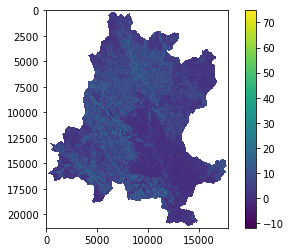

In [12]:
fig, ax = plt.subplots()
c = plt.imshow(chm_3m_m)
plt.colorbar(c)

In [31]:
canopy_pixels_count = (chm_3m_m > 2).sum()
canopy_pixels_count.values

array(87832297)

In [32]:
noncanopy_pixels_count = (chm_3m_m <= 2).sum()
noncanopy_pixels_count.values

array(113256431)

In [37]:
percent_canopy = (canopy_pixels_count.values / (canopy_pixels_count.values + noncanopy_pixels_count.values)) * 100
percent_canopy

43.678379128242334

In [38]:
# Find out how many pixels are masked using code from:
# https://gis.stackexchange.com/questions/382289/count-no-data-pixel-with-rioxarray

valid_px_count = int(chm_3m_m.count().compute())
total_px_count = chm_3m_m.size

nodata_px_count = total_px_count - valid_px_count
nodata_px_count

179206977

### Double check calculations

In [39]:
chm_3m_m.size

380295705

In [40]:
canopy_pixels_count.values + noncanopy_pixels_count.values + nodata_px_count

380295705

Seems to check out!

#### Tuolumne Canopy Cover  
Same method as for the Methow, but the CHM already exists

In [63]:
tuol_chm = rxr.open_rasterio('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m_ma.tif', masked=True).squeeze()
tuol_chm_src = rio.open('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m.tif')

tuol_outline = gpd.read_file('../../data/site_outlines/UpperTuolRiverBasinOutline.geojson')
tuol_outline_nolakes = pickle.load(open('../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

<AxesSubplot:>

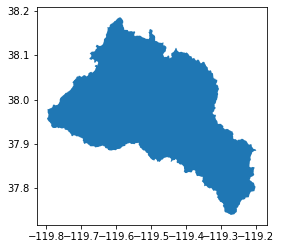

In [50]:
tuol_outline[1:].plot()

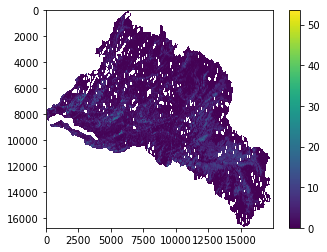

In [64]:
fig, ax = plt.subplots()
c = plt.imshow(tuol_chm)
plt.colorbar(c)

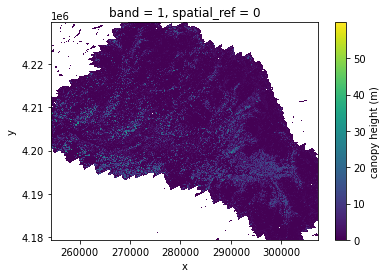

In [53]:
fig, ax = plt.subplots()
tuol_chm.plot()
#tuol_outline[1:].plot(facecolor=None, edgecolor='k')

In [60]:
shape = tuol_outline_nolakes.loc[0, 'geometry']

In [61]:
with rio.open('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m.tif') as src:
    out_image, out_transform = rio.mask.mask(src, shape, crop=True)
    out_meta = src.meta

In [62]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open('../../data/lidar/tuolumne/USCATB20140827_chm_3p0m_ma.tif', "w", **out_meta) as dest:
    dest.write(out_image)

#### Calculate Percent Canopy Cover (CHM pixels > 2m) for Tuolumne:  
As per Currier et al., 2019: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018WR024533

In [65]:
canopy_pixels_count = (tuol_chm > 2).sum()
canopy_pixels_count.values

array(39521235)

In [66]:
noncanopy_pixels_count = (tuol_chm <= 2).sum()
noncanopy_pixels_count.values

array(89537350)

In [67]:
percent_canopy = (canopy_pixels_count.values / (canopy_pixels_count.values + noncanopy_pixels_count.values)) * 100
percent_canopy

30.622709058835568

In [68]:
# Find out how many pixels are masked using code from:
# https://gis.stackexchange.com/questions/382289/count-no-data-pixel-with-rioxarray

valid_px_count = int(tuol_chm.count().compute())
total_px_count = tuol_chm.size

nodata_px_count = total_px_count - valid_px_count
nodata_px_count

163897243

### Double check calculations

In [69]:
tuol_chm.size

292955828

In [70]:
canopy_pixels_count.values + noncanopy_pixels_count.values + nodata_px_count

292955828

Seems to check out!

### Eco Zone Assessment  
Bonus. Not used in the manuscript.

In [23]:
ecozone = gpd.read_file('../../data/site_outlines/wwf_terr_ecos/wwf_terr_ecos.shp')
tuol_outline = gpd.read_file('../../data/site_outlines/UpperTuolRiverBasinOutline.geojson')
methow_outline = gpd.read_file('../../data/site_outlines/methow_outline.geojson')
gm_outline = gpd.read_file('../../data/site_outlines/gm_outline.geojson')

In [19]:
pd.set_option('display.max_columns', None)

<AxesSubplot:>

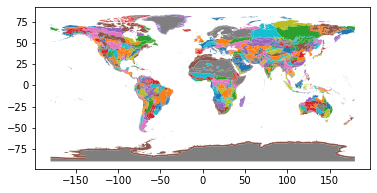

In [13]:
ecozone.plot(column='ECO_NAME')

In [26]:
ecozone_clipped = gpd.overlay(tuol_outline, ecozone, how='intersection')

<AxesSubplot:>

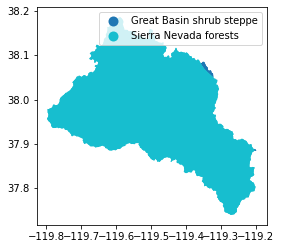

In [31]:
ecozone_clipped.plot(column='ECO_NAME', legend=True)


In [33]:
ecozone_methow = gpd.overlay(methow_outline, ecozone, how='intersection')

<AxesSubplot:>

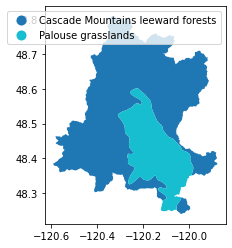

In [34]:
ecozone_methow.plot(column='ECO_NAME', legend=True)